In [ ]:
!pip install wandb
!wandb login a4d0941kdc05b344bbe7a51be296e69f130902fb2

     |████████████████████████████████| 1.4MB 3.3MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 163kB 13.7MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 112kB 11.1MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 71kB 5.2MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=9ef38ab3d0743652f8792e428a925fa1e02f92be60d8a167a6a280f2561c5398
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=4bc0a67d88383564016275b1b2f2f1ea36ddfbfa98a581e330e6f70a9f015c3c
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=45e0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import json
import os
import shutil
import numpy as np
from glob import glob

import wandb
from wandb.keras import WandbCallback

In [ ]:
!pip -q install kaggle
!mkdir /root/.kaggle

token = {"username":"raqhea","key":"6945807e6399316dfb405a62642dcd12"}
with open('/root/.kaggle/kaggle.json', 'w') as f:
  json.dump(token, f)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# download the dataset
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 42.0MB/s]
 98% 534M/544M [00:03<00:00, 161MB/s]
100% 544M/544M [00:03<00:00, 144MB/s]
 99% 268M/271M [00:02<00:00, 113MB/s]
100% 271M/271M [00:02<00:00, 128MB/s]


In [ ]:
!unzip -qo test.zip
!unzip -qo train.zip

In [ ]:
# total number of train images
print('Total train dataset length:',len(glob('train/*')))
print('Total test dataset length:', len(glob('test/*')))

Total train dataset length: 25000
Total test dataset length: 12500


In [ ]:
# Let's look at class distribution
print('We have 2 classes: Dog, Cat')
print('There are %d Dog images'% len(glob('train/dog*')))
print('There are %d Cat images'% len(glob('train/cat*')))

We have 2 classes: Dog, Cat
There are 12500 Dog images
There are 12500 Cat images


In [ ]:
# split the categories by creating different directories for classes
file_list = os.listdir('train')
os.mkdir('train/Cat')
os.mkdir('train/Dog')


# I'll split the data in order to create balanced splits 
for f_name in file_list:
  f_path = os.path.join('train', f_name)
  label = f_name[:3]
  if label == 'cat':
    shutil.move(f_path, 'train/Cat')
  elif label == 'dog':
    shutil.move(f_path, 'train/Dog') 

In [ ]:
# now we can create train/validation/test splits
base_path = 'dataset'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

paths = [test_path, val_path, train_path]
# create a directories for splits
os.mkdir(base_path)
os.mkdir(train_path)
os.mkdir(val_path)
os.mkdir(test_path)
# create categorical directories for splits
for path in paths:
  cat_path = os.path.join(path, 'Cat')
  dog_path = os.path.join(path, 'Dog')
  os.mkdir(cat_path)
  os.mkdir(dog_path)
# move the files according to categories for every single split
# 20% of the training data will be used as test set while other 20% of training data will be used as validation set 
test_ratio = 0.2
val_ratio = 0.2
train_ratio = 1 - test_ratio - val_ratio
# get the total number of files for each split
total = len(file_list)
N_train = int(total*train_ratio)
N_test = int(total*test_ratio)
N_validation = int(total*val_ratio)
# files of different categories
cat_files = glob('train/Cat/*')
dog_files = glob('train/Dog/*')
# get the balanced splits
test_files = cat_files[:N_test//2] + dog_files[:N_test//2]
val_files = cat_files[N_test//2: (N_test + N_validation)//2] + dog_files[N_test//2: (N_test + N_validation)//2]
train_files = cat_files[-N_train//2:] + dog_files[-N_train//2:] # Equivalent with "file_list[(N_test + N_validation)//2:]"
# finally we can move them to their own directories
for file_list, path in zip([test_files, val_files, train_files], paths):
  for f_path in file_list:
    label = f_path[10:13] # example file path: train/Dog/dog.1234.jpg
    if label == 'cat':
      shutil.move(f_path, os.path.join(path, 'Cat'))
    elif label == 'dog':
      shutil.move(f_path, os.path.join(path, 'Dog'))

In [ ]:
# sanity check
glob('dataset/train/Cat/*')
# we separated the data successfully

In [ ]:
# initalize the configuration of the model
adam_params = {
     'learning_rate':0.001, 
     'beta_1':0.9, 
     'beta_2':0.999, 
     'epsilon':1e-07, 
     'amsgrad':False
}
rmsprop_params = {
    'learning_rate':0.001,
    'rho':0.9,
    'momentum':0.0, 
    'epsilon':1e-07,
    'centered':False,
}
sgd_params = {
    'learning_rate' : 0.045,
    'momentum':0.9,
    'nesterov':True
}
opts = {
    'adam': optimizers.Adam(**adam_params),
    'rmsprop': optimizers.RMSprop(**rmsprop_params),
    'sgd': optimizers.SGD(**sgd_params)
}

config = {
    'batch_size' : 64,
    'image_size' : [150,150],
    'seed' : 42,
    'optimizer' : 'adam',
    'opt_params' : adam_params,
    'initial_learning_rate' : 0.045,
    'validation_steps' : 50,
    'steps_per_epoch' : 100,
    'epochs' : 50
}

wandb.init(
    project = 'cats-vs-dogs-kaggle',
    config = config
)
config = wandb.config

In [ ]:
# create image generators to create a dataset as Python generator 
train_gen = ImageDataGenerator(rescale = 1./255,
                               horizontal_flip = True,
                               vertical_flip = True,
                               fill_mode = 'nearest',
                               shear_range = .15,
                               zoom_range = .15,
                               rotation_range = 45)
val_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

# now create a flow from directory that generates data for us 
train_ds = train_gen.flow_from_directory(train_path,
                                         target_size = tuple(config.image_size),
                                         class_mode = 'binary',
                                         batch_size = config.batch_size,
                                         seed = config.seed)
val_ds = val_gen.flow_from_directory(val_path,
                                        target_size = tuple(config.image_size),
                                        class_mode = 'binary',
                                        batch_size = config.batch_size,
                                        seed = config.seed)
test_ds = test_gen.flow_from_directory(test_path,
                                       class_mode = 'binary',
                                       target_size = tuple(config.image_size),
                                       batch_size = config.batch_size)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
def build_model(input_shape, num_classes):
  inputs = layers.Input(shape = input_shape)

  # entry
  x = layers.Conv2D(32, 3, strides = 2, padding = 'same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  r = x

  for size in [128, 256, 512, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3,2, padding = 'same')(x)

    # project residual
    conv_res = layers.Conv2D(size, 1, strides = 2, padding = 'same')(r)
    x = layers.add([x, conv_res])
    r = x
  
  x = layers.SeparableConv2D(1024, 3, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes > 2: 
    K = num_classes
    activation = 'softmax'
  else:
    K = 1
    activation = 'sigmoid'
  
  x = layers.Dropout(.5)(x)
  x = layers.Dense(K, activation = activation)(x)

  model = models.Model(inputs = inputs, outputs = x)
  print(model.summary())
  return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 75, 75, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 75, 75, 32)   128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 75, 75, 32)   0           batch_normalization_7[0][0]      
_______________________________________________________________________________________

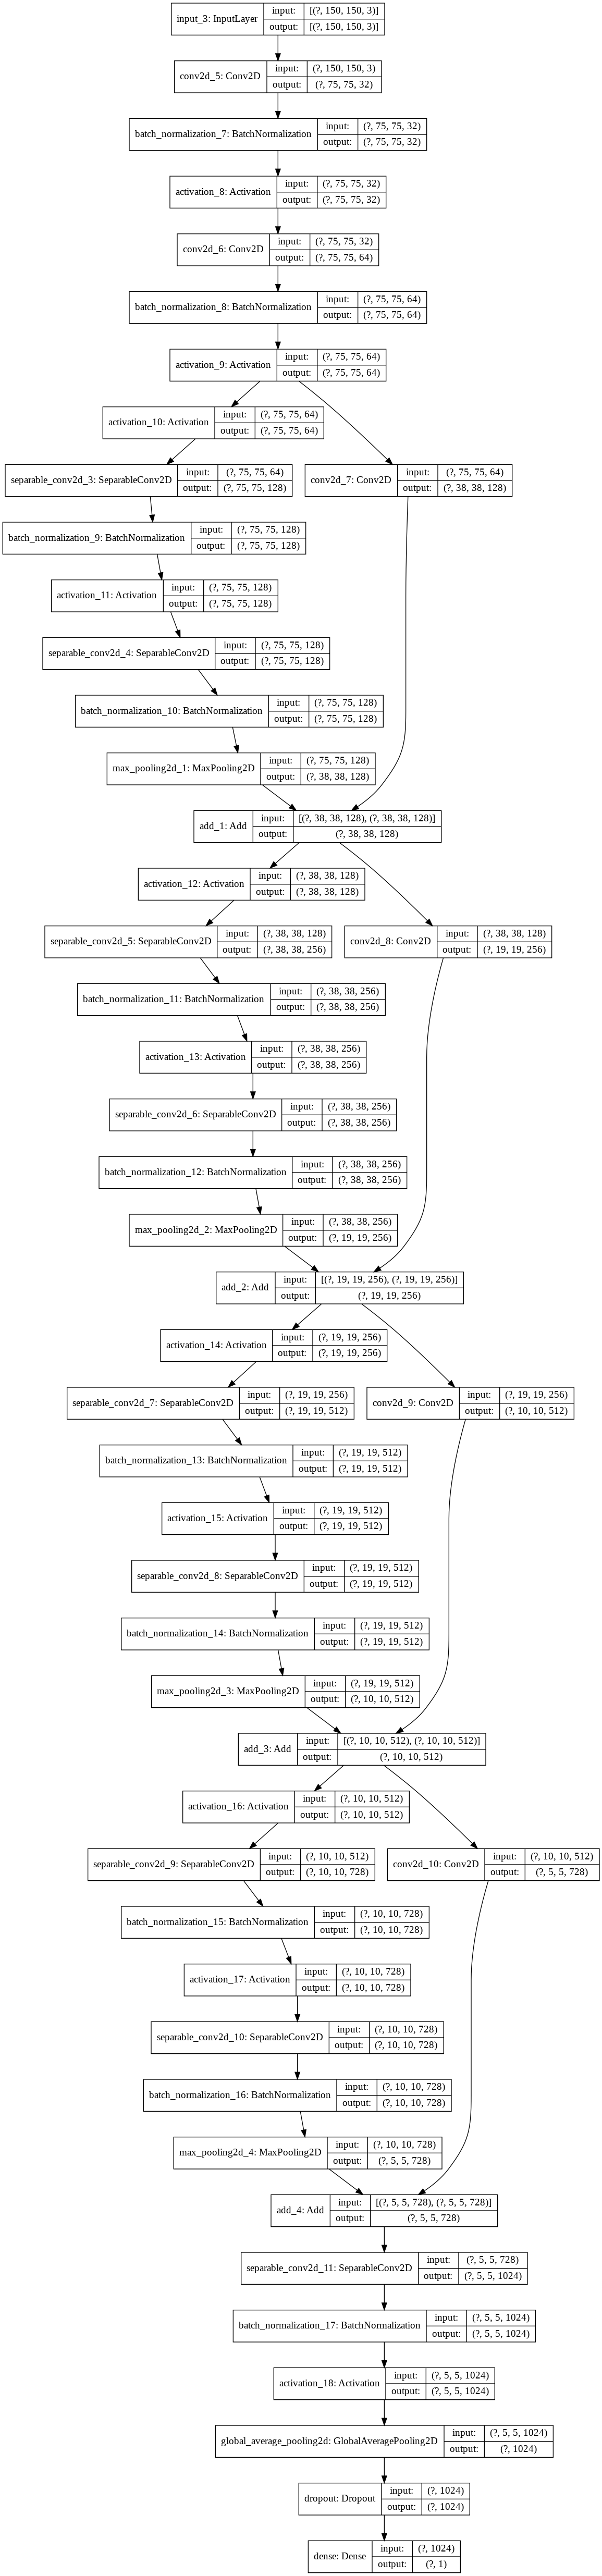

In [ ]:
model = build_model(tuple(config.image_size + [3]), 2)

model.compile(loss = 'binary_crossentropy',
              optimizer = opts[config.optimizer],
              metrics = ['acc'])

plot_model(model, show_shapes = True)

In [ ]:
def lr_scheduler(epochs, lr):
  if epochs % 2 == 0:s
    lr = lr * 0.94
    return lr
  else:
    return lr
8
# train the model
r = model.fit(train_ds, validation_data = val_ds,
              # steps_per_epoch = config.steps_per_epoch,
              # validation_steps = config.validation_steps, 
              epochs = config.epochs,
              callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
                           WandbCallback(data_type = 'image')])

model.save('mini-xception_catsvsdogs.h5')

Epoch 1/50
235/235 [==============================] - 196s 833ms/step - loss: 0.6350 - acc: 0.6574 - val_loss: 0.7356 - val_acc: 0.5000
Epoch 2/50
235/235 [==============================] - 192s 818ms/step - loss: 0.5281 - acc: 0.7408 - val_loss: 0.9024 - val_acc: 0.5018
Epoch 3/50
235/235 [==============================] - 190s 807ms/step - loss: 0.4836 - acc: 0.7681 - val_loss: 0.6093 - val_acc: 0.6684
Epoch 4/50
235/235 [==============================] - 189s 805ms/step - loss: 0.4495 - acc: 0.7921 - val_loss: 0.5741 - val_acc: 0.7238
Epoch 5/50
235/235 [==============================] - 190s 807ms/step - loss: 0.4057 - acc: 0.8184 - val_loss: 0.9943 - val_acc: 0.7146
Epoch 6/50
235/235 [==============================] - 191s 811ms/step - loss: 0.3825 - acc: 0.8310 - val_loss: 0.4295 - val_acc: 0.7988
Epoch 7/50
235/235 [==============================] - 190s 810ms/step - loss: 0.3474 - acc: 0.8439 - val_loss: 0.7612 - val_acc: 0.7132
Epoch 8/50
235/235 [============================

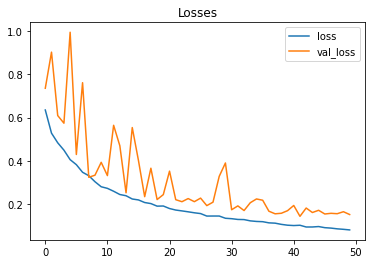

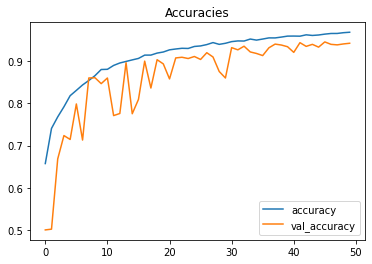

In [ ]:
plt.title('Losses')
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.title('Accuracies')
plt.plot(r.history['acc'], label = 'accuracy')
plt.plot(r.history['val_acc'], label = 'val_accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_ds)

79/79 [==============================] - 17s 213ms/step - loss: 0.1501 - acc: 0.9456


[0.1501188725233078, 0.9455999732017517]